In [11]:
import pandas as pd
import georinex as gr
import misc
from plots import *
import matplotlib.dates as mdates
import datetime
import matplotlib
import copy

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from logparser import LogReader, PosReader

# Prepare the data

In [12]:
# Load log files
measurements_log = ['Raw', 'Fix']
measurements_RINEX = ['C1C']
logs = []

log = LogReader(manufacturer="Google", device="Pixel 7", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_GooglePixel7_20230801110405_modified.txt")
# log.ref = gr.load('../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230480000_01D_30S_MO.rnx',
#               tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
#               meas=measurements_RINEX)
logs.append(log)

log = LogReader(manufacturer="Google", device="Pixel Watch", specifiedTags=measurements_log, mode="mimir", 
                filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_GooglePixelWatch_20230801110404_modified.txt")
# log.ref = gr.load('../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20232260000_01D_30S_MO.rnx',
#               tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
#               meas=measurements_RINEX)
logs.append(log)

log = LogReader(manufacturer="OnePlus", device="Nord 2", specifiedTags=measurements_log, mode="mimir", 
                filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_OnePlusNord2_20230811103018_modified.txt")
# log.ref = gr.load('../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230620000_01D_30S_MO.rnx',
#               tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
#               meas=measurements_RINEX)
logs.append(log)

log = LogReader(manufacturer="Samsung", device="A52", specifiedTags=measurements_log, mode="mimir", 
                filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_SamsungA52_20230811101903_modified.txt")
# log.ref = gr.load('../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230760000_01D_30S_MO.rnx',
#               tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
#               meas=measurements_RINEX)
logs.append(log)

log = LogReader(manufacturer="Xiaomi", device="11T", specifiedTags=measurements_log, mode="mimir", 
                filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_Xiaomi11T_20230801111451_modified.txt")
# log.ref = gr.load('../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230620000_01D_30S_MO.rnx',
#               tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
#              meas=measurements_RINEX)
logs.append(log)


In [13]:
log.raw.loc[log.raw['prn'].isin(['G30-L1']), ['TimeNanos', 'AccumulatedDeltaRangeMeters', 'PhaseVelocity', 'PhaseError']]


,TimeNanos,AccumulatedDeltaRangeMeters,PhaseVelocity,PhaseError
datetime,,,,
2023-08-01 08:14:59.143,2.674700e+10,8413.963655,NaN,NaN
2023-08-01 08:15:00.137,2.774700e+10,9563.053914,1149.090259,NaN
2023-08-01 08:15:01.121,2.873700e+10,10708.743629,1157.262339,8.254625
2023-08-01 08:15:05.126,3.273700e+10,15325.507785,1154.191039,-0.767825
2023-08-01 08:15:10.121,3.773700e+10,21081.590031,1151.216449,-0.594918
...,...,...,...,...
2023-08-01 08:24:09.137,5.767380e+11,517533.938259,1196.602998,-0.180350
2023-08-01 08:24:13.149,5.807380e+11,522319.996399,1196.514535,-0.022116
2023-08-01 08:24:14.138,5.817380e+11,523516.030680,1196.034281,-0.480254


In [14]:
# Compute ENU errors
ref_enu = [61.44922404, 23.8562781, 162.711]
for log in logs:
    log.fix[["east", "north", "up"]] = log.fix.apply(
        lambda row: misc.convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')
    
    log.fix[["2D_error"]] = log.fix.apply(
        lambda row: misc.getHorizontalError(row['east'], row['north']), 
        axis='columns', result_type='expand')
    
    log.fix[["3D_error"]] = log.fix.apply(
        lambda row: misc.get3DError(row['east'], row['north'], row['up']), 
        axis='columns', result_type='expand')

# Results

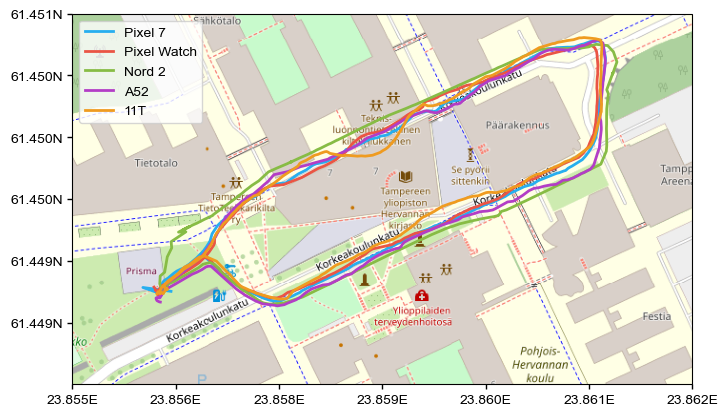

In [33]:
center = ref_enu[:2]
extent = [center[1] - 0.02, center[1] + 0.005, center[0] - 0.005, center[0] + 0.005]
extent = [center[1] - 0.001, center[1] + 0.006, center[0] - 0.0005, center[0] + 0.0015]
#extent = [center[1] - 0.0002, center[1] + 0.0002, center[0] - 0.0001, center[0] + 0.0001]

locations = {}
for log in logs:
    locations[log.device] = log.fix.loc[log.fix['provider'].isin(['GPS']), ["latitude", "longitude"]]

plotMap(locations=locations, extent=extent, scale=17)

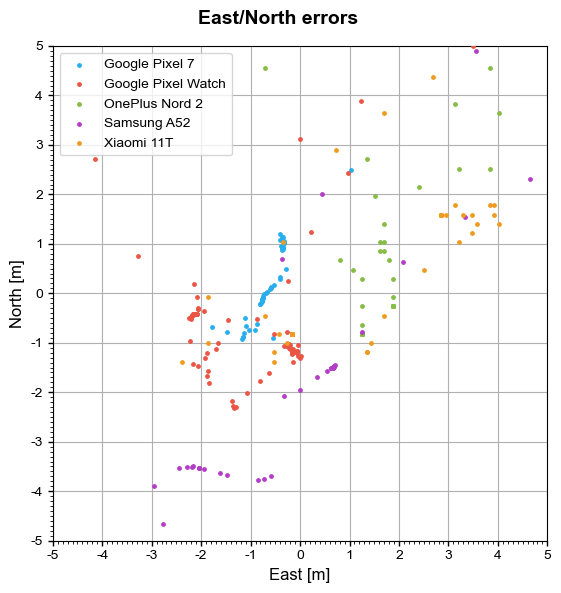

In [16]:
plotEN(logs, lim=5, ticks=[0.1, 1])

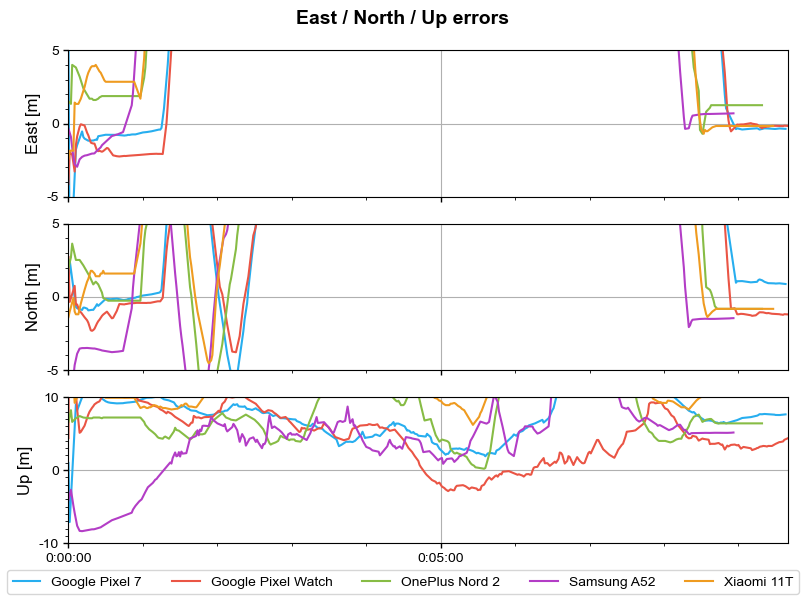

In [17]:
plotENU(logs, lim=[5,5,10], ticks=[1, 5, 1, 5, 1, 10])

### Visibility

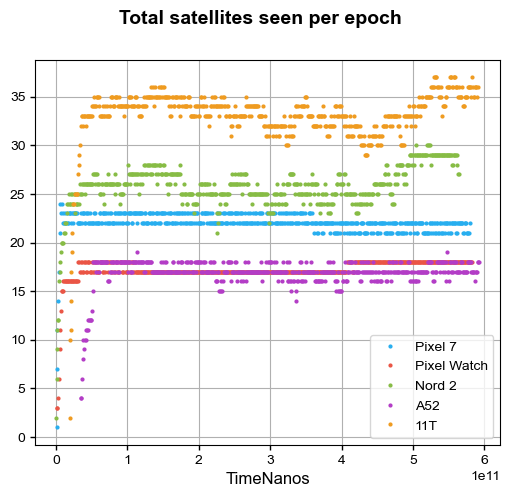

In [18]:
plotTotalSatellitesPerEpochs(logs)

AttributeError: 'LogReader' object has no attribute 'ref'

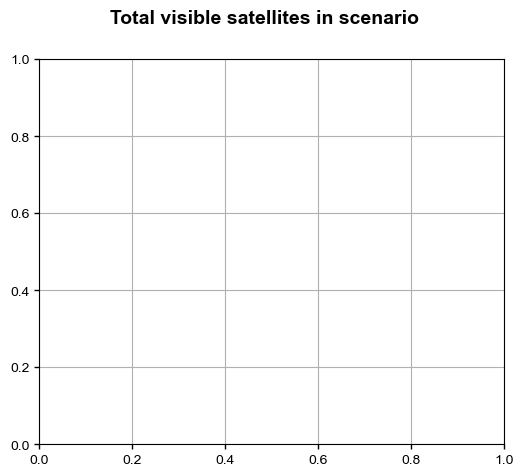

In [19]:
plotTotalSatellitesBar(logs, normalised=False)

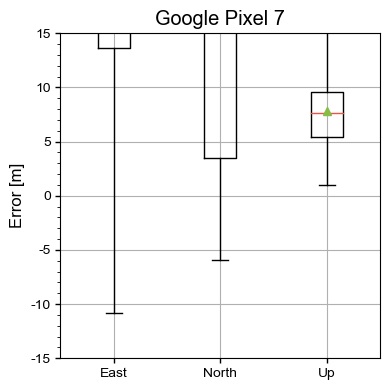

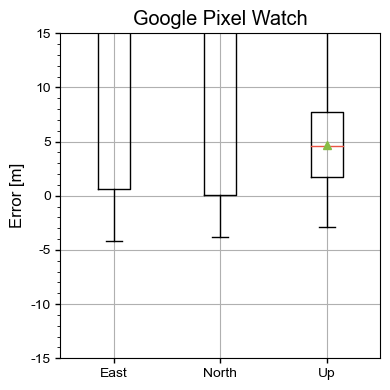

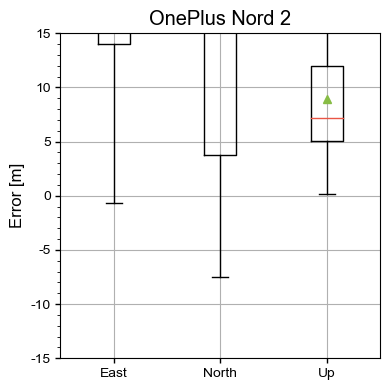

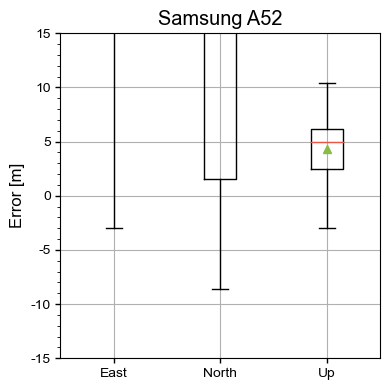

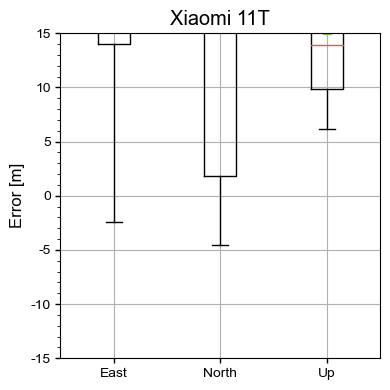

In [34]:
plotStatisticsENU(logs, lim=15, ticks=[1, 5], mode='box')

### Measurements

Pseudoranges

Rows removed 7 (0.058%)
Rows removed 15 (0.165%)
Rows removed 90 (0.648%)
Rows removed 2 (0.022%)
Rows removed 131 (0.733%)


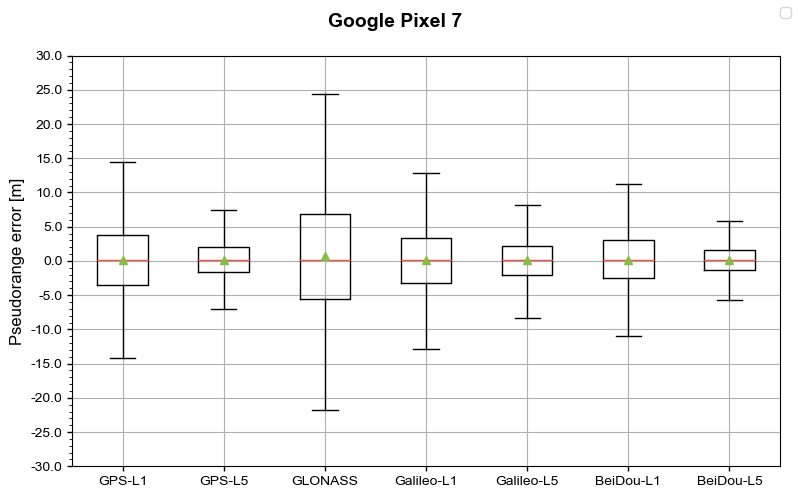

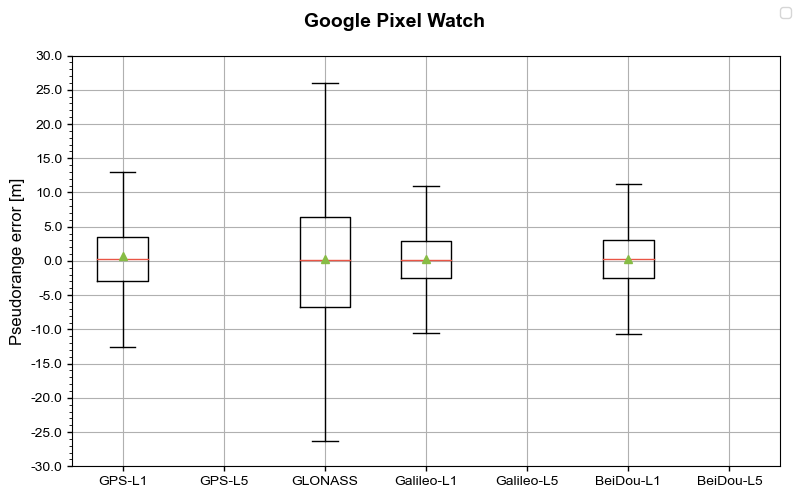

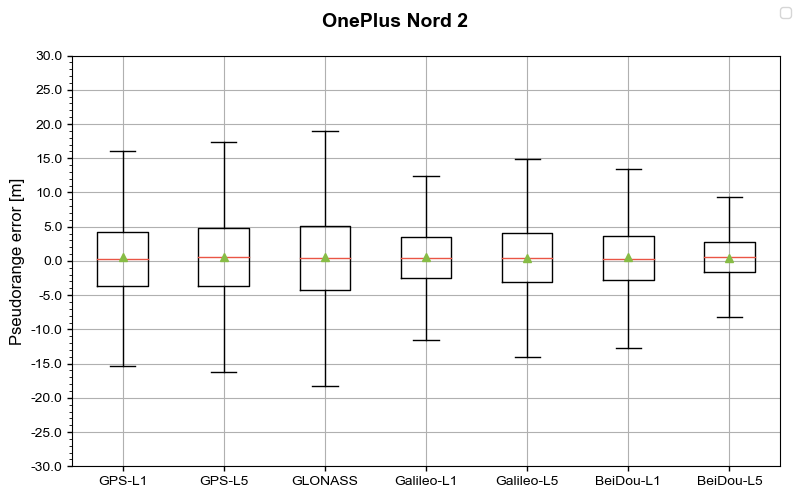

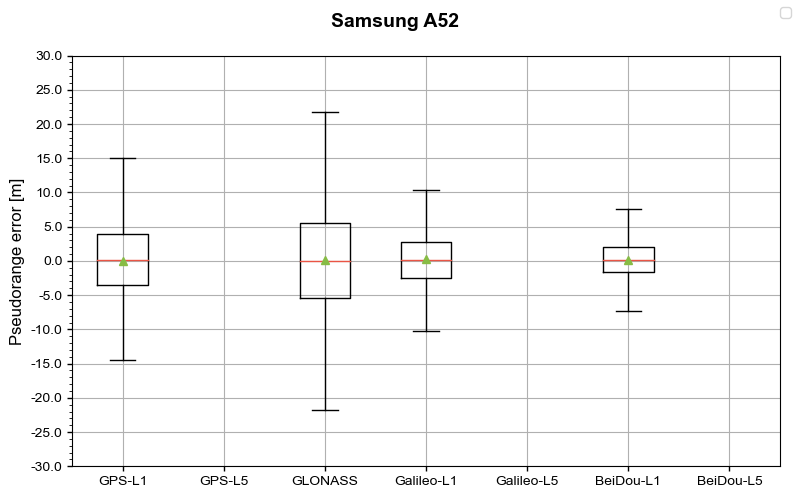

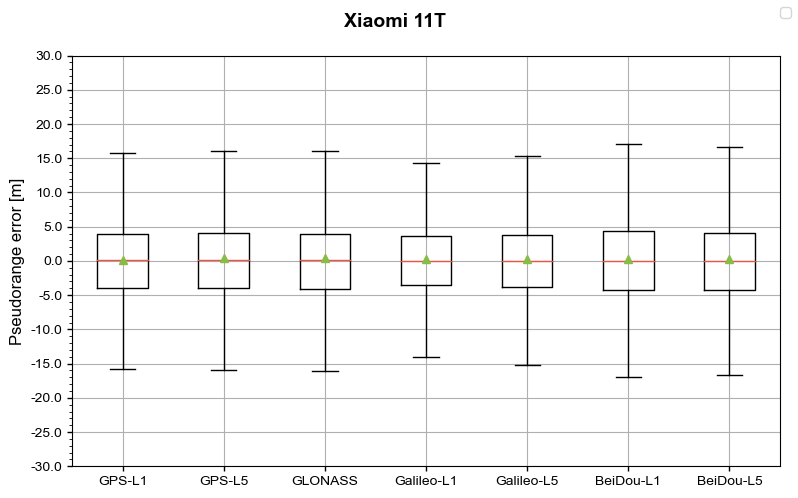

In [35]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw = misc.filterValues(log.raw, 'PseudorangeAcceleration', 300)
    log.raw[list(misc.GnssState_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['State'], bits=17, type='tracking'), axis='columns', result_type='expand')
plotStatisticsDataBox(_logs, 
                      'PseudorangeAcceleration', 
                      'Pseudorange error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=30,
                      ticks=[1,5])

In [36]:
for log in _logs:
    print(f"--- {log.device} ---")
    count = log.raw[list(misc.GnssState_Str.values())].count()
    df = log.raw[list(misc.GnssState_Str.values())].sum().div(count).mul(100).transpose()
    print(df)

--- Pixel 7 ---
TRACK_UNKNOWN                   0.000000
TRACK_CODE_LOCK                72.316525
TRACK_BIT_SYNC                 77.600266
TRACK_SUBFRAME_SYNC            46.172408
TRACK_TOW_DECODED              37.002829
TRACK_MSEC_AMBIGUOUS            0.000000
TRACK_SYMBOL_SYNC              77.600266
TRACK_GLO_STRING_SYNC           2.321518
TRACK_GLO_TOD_DECODED           2.321518
TRACK_BDS_D2_BIT_SYNC           0.000000
TRACK_BDS_D2_SUBFRAME_SYNC      0.000000
TRACK_GAL_E1BC_CODE_LOCK       15.809619
TRACK_GAL_E1C_2ND_CODE_LOCK    29.172907
TRACK_GAL_E1B_PAGE_SYNC         0.000000
TRACK_SBAS_SYNC                 0.000000
TRACK_TOW_KNOWN                97.678482
TRACK_GLO_TOD_KNOWN             2.321518
TRACK_S_2ND_CODE_LOCK          63.929106
dtype: float64
--- Pixel Watch ---
TRACK_UNKNOWN                   0.000000
TRACK_CODE_LOCK                64.523599
TRACK_BIT_SYNC                 89.358183
TRACK_SUBFRAME_SYNC            49.536833
TRACK_TOW_DECODED              49.702250
TRACK_

Doppler

Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)


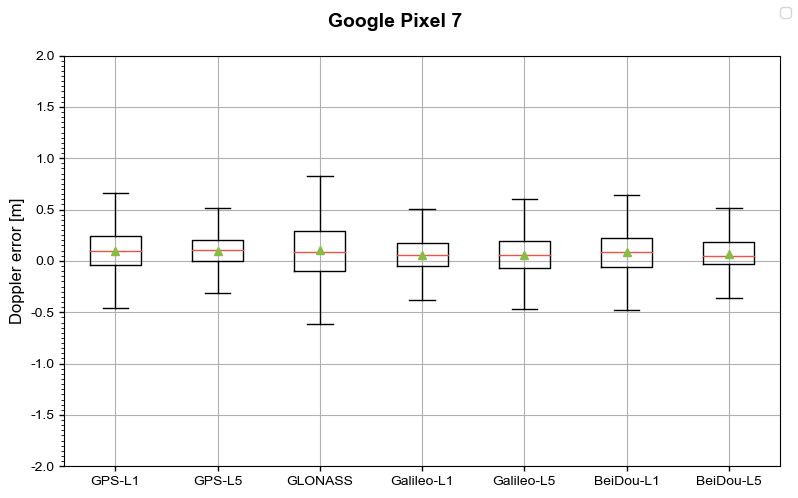

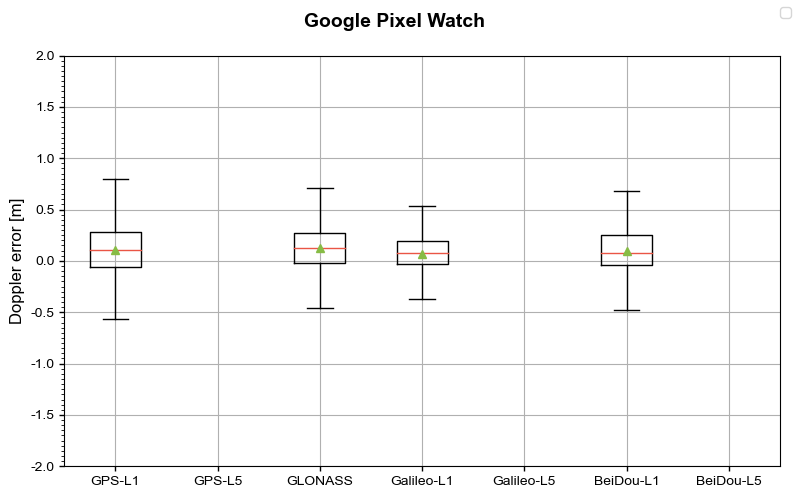

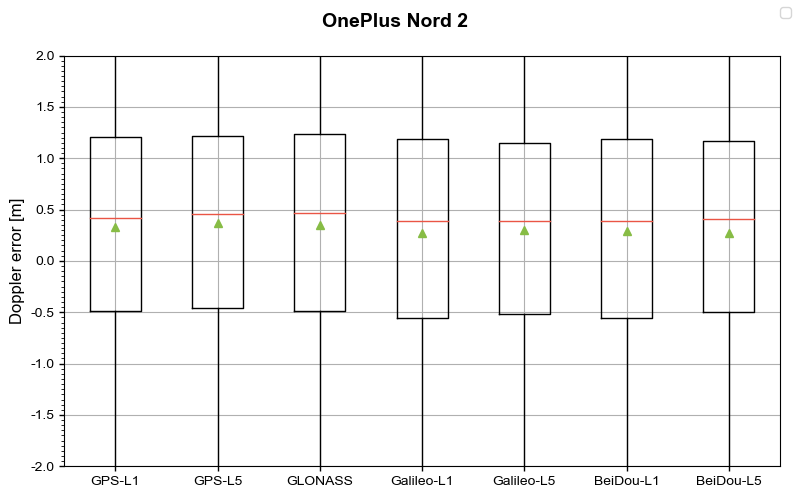

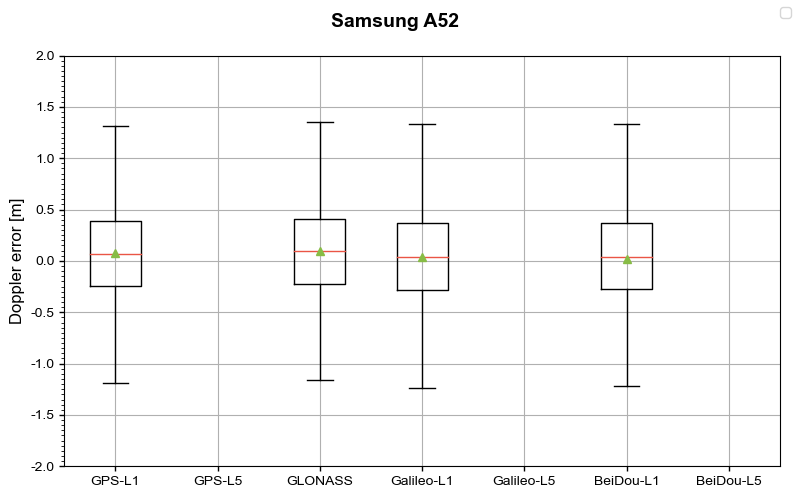

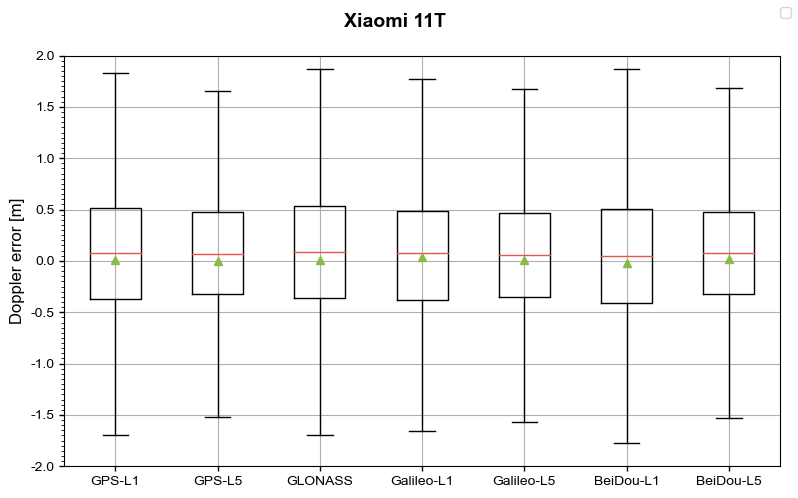

In [37]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw = misc.filterValues(log.raw, 'DopplerError', 300)
plotStatisticsDataBox(_logs, 
                      'DopplerError', 
                      'Doppler error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5])

Phases

--- Pixel 7 ---
count    12613.000000
mean         0.094290
std          0.722353
min         -5.040536
50%          0.076187
66.7%        0.149087
95%          1.156166
99.7%        3.606236
max          5.051482
Name: PhaseError, dtype: float64
--- Pixel Watch ---
count    9896.000000
mean        0.116836
std         0.630903
min        -3.725267
50%         0.098341
66.7%       0.221584
95%         1.119873
99.7%       2.751180
max         3.764223
Name: PhaseError, dtype: float64
--- Nord 2 ---
count    14353.000000
mean         0.344732
std         24.585128
min       -558.448801
50%          0.410435
66.7%        0.895357
95%          3.203574
99.7%       95.188882
max        541.041648
Name: PhaseError, dtype: float64
--- A52 ---
count    0.0
mean     NaN
std      NaN
min      NaN
50%      NaN
66.7%    NaN
95%      NaN
99.7%    NaN
max      NaN
Name: PhaseError, dtype: float64
--- 11T ---
count    18704.000000
mean         0.043910
std         50.731679
min       -953.921149
50%

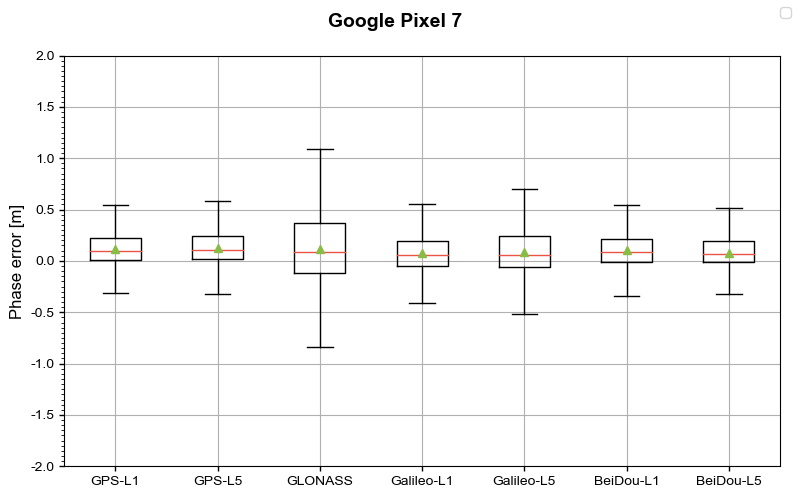

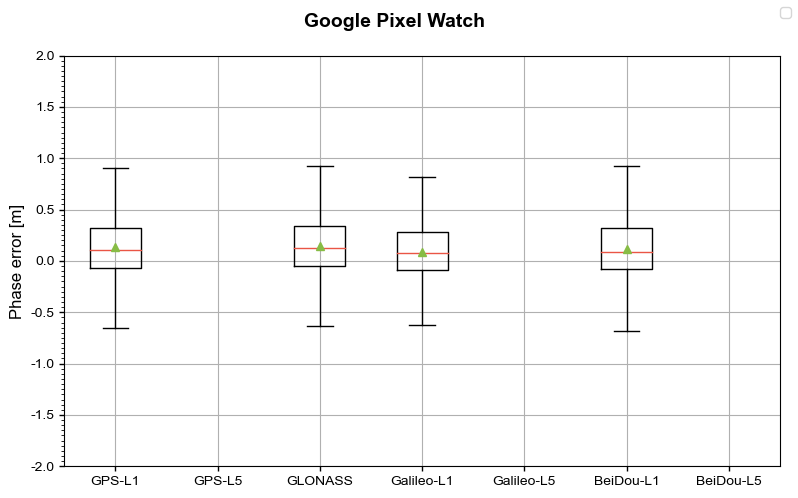

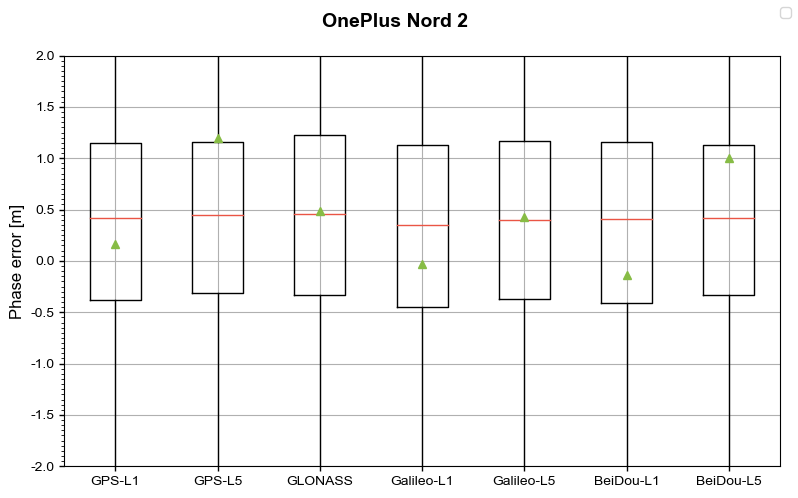

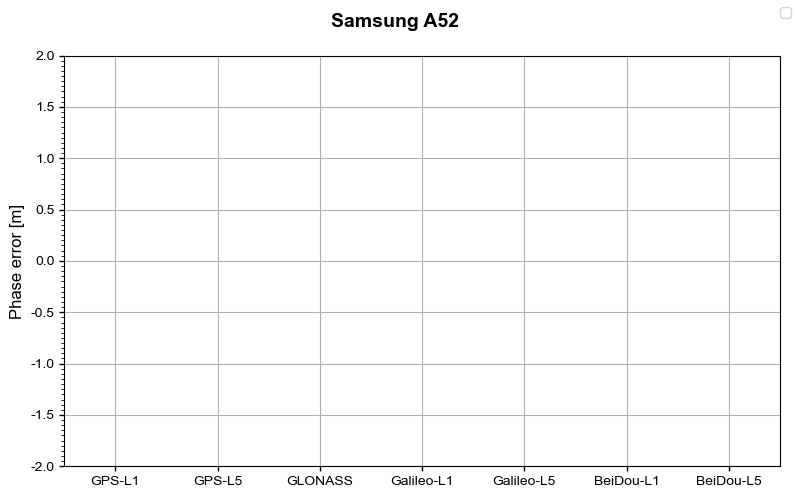

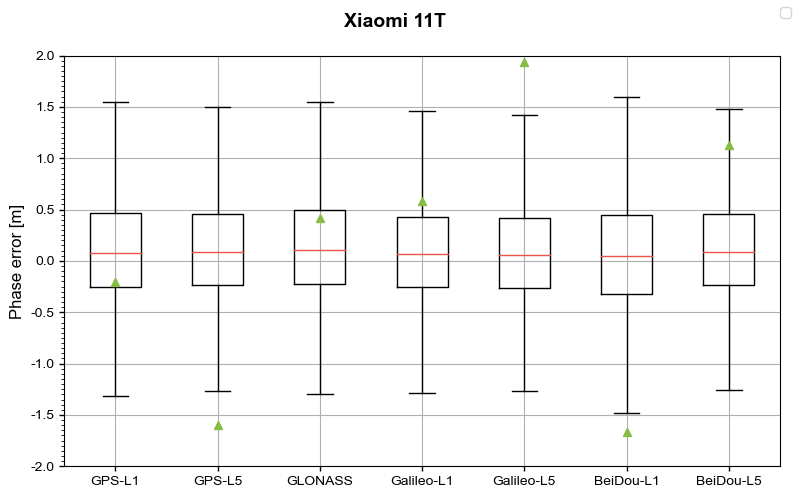

In [38]:
_logs = copy.deepcopy(logs)
for log in _logs:
    print(f"--- {log.device} ---")
    log.raw = misc.filterPercentile(log.raw, 'PhaseError', 0.997)
    print(log.raw['PhaseError'].describe(percentiles=[0.5, .667, .95, .997]).T)
plotStatisticsDataBox(_logs, 
                      'PhaseError', 
                      'Phase error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5])
    

In [ ]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw[list(misc.GnssStateADR_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['AccumulatedDeltaRangeState'], bits=5, type='phase'), axis='columns', result_type='expand')


In [ ]:
for log in _logs:
    print(f"--- {log.device} ---")
    count = log.raw[list(misc.GnssStateADR_Str.values())].count()
    print(log.raw[list(misc.GnssStateADR_Str.values())].sum().div(count).mul(100))

--- Pixel 7 ---
ADR_UNKNOWN                  0.000000
ADR_VALID                   76.770878
ADR_RESET                    0.000000
ADR_CYCLE_SLIP               0.566681
ADR_HALF_CYCLE_RESOLVED     72.644031
ADR_HALF_CYCLE_REPORTED    100.000000
dtype: float64
--- Pixel Watch ---
ADR_UNKNOWN                  0.000000
ADR_VALID                   78.832487
ADR_RESET                    0.005972
ADR_CYCLE_SLIP               4.643177
ADR_HALF_CYCLE_RESOLVED     67.611227
ADR_HALF_CYCLE_REPORTED    100.000000
dtype: float64
--- Nord 2 ---
ADR_UNKNOWN                  0.000000
ADR_VALID                   82.392986
ADR_RESET                    0.000000
ADR_CYCLE_SLIP               7.858327
ADR_HALF_CYCLE_RESOLVED     77.790019
ADR_HALF_CYCLE_REPORTED    100.000000
dtype: float64
--- A52 ---
ADR_UNKNOWN                  0.0
ADR_VALID                    0.0
ADR_RESET                    0.0
ADR_CYCLE_SLIP               0.0
ADR_HALF_CYCLE_RESOLVED      0.0
ADR_HALF_CYCLE_REPORTED    100.0
dtype: flo

C/N0

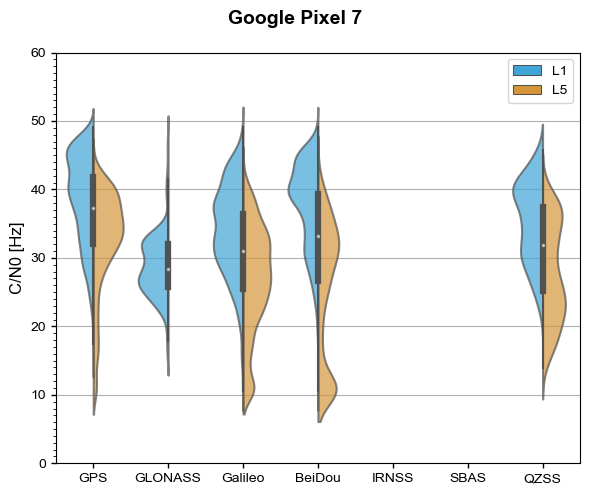

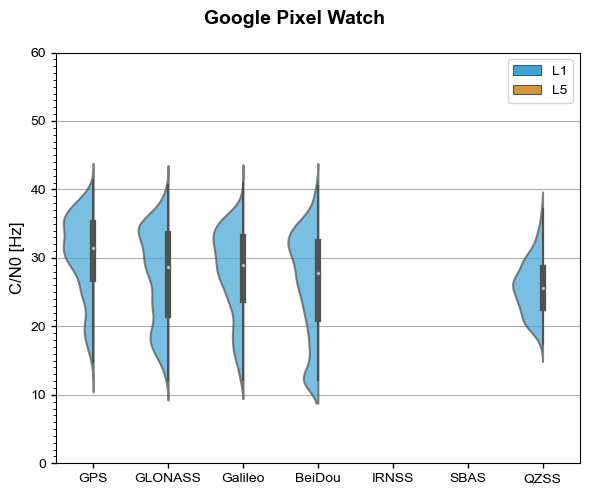

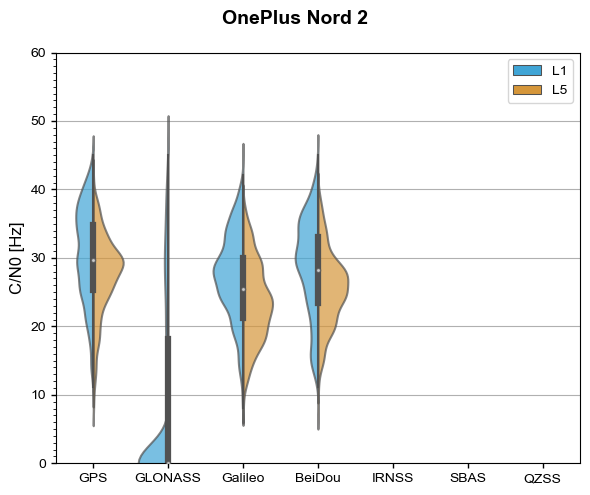

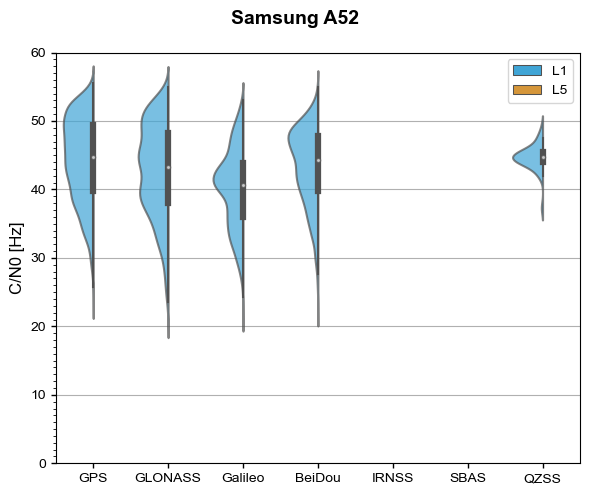

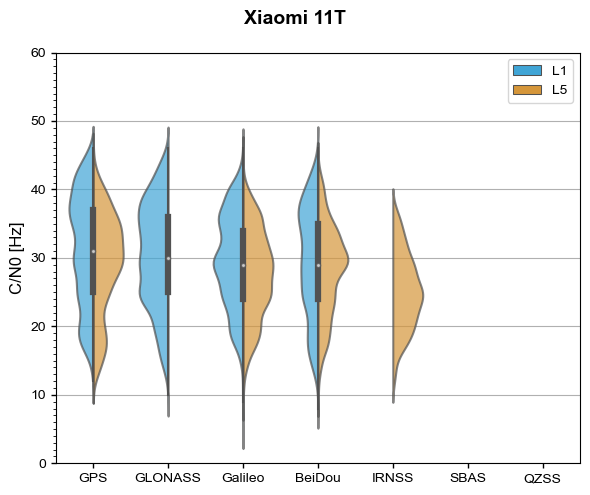

In [39]:
_logs = copy.deepcopy(logs)
plotStatisticsDataViolin(
    _logs, 
    'Cn0DbHz', 
    'C/N0 [Hz]', 
    ('G', 'R', 'E', 'C', 'I', 'S', 'J'), 
    ('L1', 'L5'),
    lim=60,
    ticks=[1,10])